# IAU Projekt - Fáza 4 - Aktivity na cvičení
Peter Brenkus, Tomáš Brček

Percentuálny podiel: 50/50

In [1]:
import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

2024-12-03 16:12:17.647923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [149]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

IMAGE_SIZE = 128
BATCH_SIZE = 16

base_path = "data/head_ct"

# 4.1 EDA and data preprocessing

## A

EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

In [3]:
labels = pd.read_csv("data/labels.csv", index_col="id")

In [4]:
files = sorted(os.listdir(path=base_path))
normal_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 0)]
hemorrhage_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 1)]
print(f'Num. normal: {len(normal_imgs)}, num. hemorrhage: {len(hemorrhage_imgs)}')

Num. normal: 100, num. hemorrhage: 100


Môžeme vidieť, že medzi obrázkami máme 100 takých, ktoré sú normálne a 100 takých, na ktorých je krvácanie. Tieto triedy sme si rozdelili do 2 polí.

### Zobrazenie vzorky

In [5]:
normal_selection = np.random.choice(normal_imgs, 5, replace = False)
hemorrhage_selection = np.random.choice(hemorrhage_imgs, 5, replace = False)

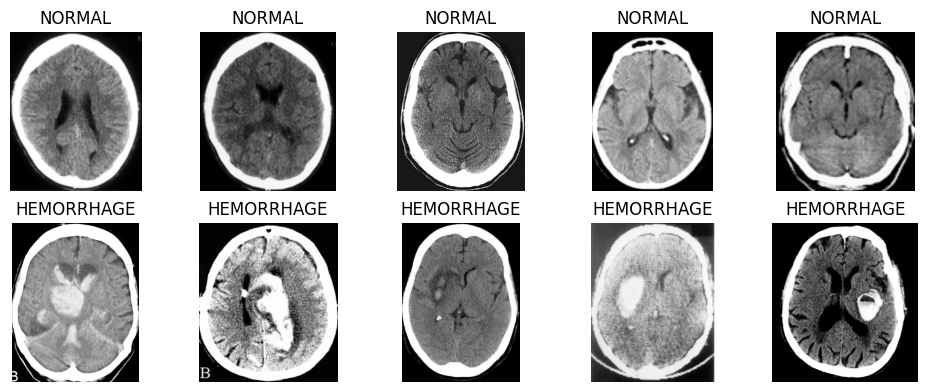

In [30]:
fig = plt.figure(figsize=(12, 12)) 
for i in range(10):
    if i < 5:
        fp = f'data/head_ct/{normal_selection[i]}'
        label = 'NORMAL'
    else:
        fp = f'data/head_ct/{hemorrhage_selection[i-6]}'
        label = 'HEMORRHAGE'
    ax = fig.add_subplot(5, 5, i+1)
    
    fn = image.load_img(fp, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

Vybrali sme vzorku 5 obrázkov z každej triedy, ktoré sme si vykreslili pre lepšiu predstavu.

### Zobrazenie priemerného príkladu

In [31]:
def convert_images_to_matrix(directory, filenames, size=(IMAGE_SIZE, IMAGE_SIZE)):
    full_matrix = None
    for filename in filenames:
        file_path = os.path.join(directory, filename)
        loaded_image = image.load_img(file_path, target_size=size, color_mode='grayscale')
        image_array = image.img_to_array(loaded_image).ravel()[np.newaxis, :]
        if full_matrix is None:
            full_matrix = image_array
        else:
            full_matrix = np.vstack((full_matrix, image_array))
    return full_matrix

normal = convert_images_to_matrix('data/head_ct/', normal_imgs)
hemorrhage = convert_images_to_matrix('data/head_ct/', hemorrhage_imgs)

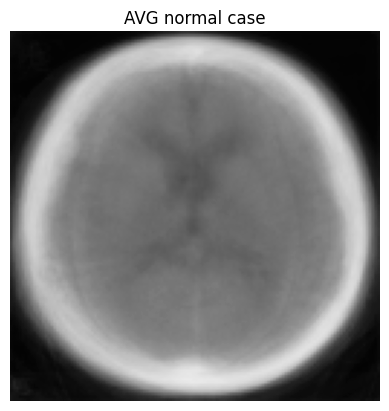

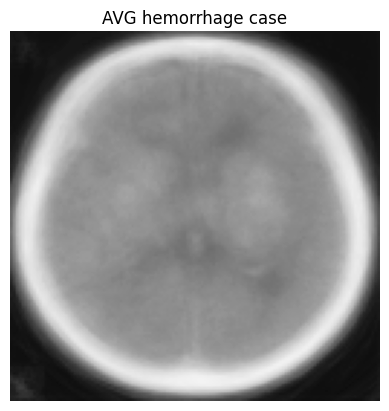

In [32]:
def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
hemorrhage_mean_img = find_mean_img(hemorrhage, 'hemorrhage')

Na obrázkoch vyššie môžeme vidieť priemerné prípady pre normálne snímky, a pre snímky, ktoré obsahujú krvácanie. 

### Príprava datasetu

In [109]:
SEED =42
tf.random.set_seed(SEED)
np.random.seed(SEED)

def load_image_and_label(image_name, label):
    img_path = tf.strings.join([base_path, image_name], separator="/")
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = img / 255.0
    return img, label

In [110]:
normal_labels = [0] * len(normal_imgs)
normal_dataset = tf.data.Dataset.from_tensor_slices((normal_imgs, normal_labels))
normal_dataset = normal_dataset.map(load_image_and_label)

In [111]:
hemorrhage_labels = [1] * len(hemorrhage_imgs)
hemorrhage_dataset = tf.data.Dataset.from_tensor_slices((hemorrhage_imgs, hemorrhage_labels))
hemorrhage_dataset = hemorrhage_dataset.map(load_image_and_label)

In [112]:
full_dataset = normal_dataset.concatenate(hemorrhage_dataset)
full_dataset = full_dataset.shuffle(buffer_size=len(full_dataset), seed=SEED, reshuffle_each_iteration=False)

#### Rozdelenie na trénovacie a testovacie dáta

In [113]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = full_dataset.skip(train_size + val_size).batch(BATCH_SIZE, drop_remainder=True)

## B

Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

# 4.2 Modeling and evaluation

## A

Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model.

In [151]:
train_dataset = full_dataset.take(train_size).batch(20, drop_remainder=True)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(20, drop_remainder=True)
test_dataset = full_dataset.skip(train_size + val_size).batch(20, drop_remainder=True) 


model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)), 
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2), 
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(96, activation='relu'),
    layers.Dropout(0.2), 
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_26 (Rescaling)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 96)             │     1,204,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260,161 (4.81 MB)

 Trainable params: 1,260,161 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003333)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5075 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.4628 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4978 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4978 - loss: 0.6916 - val_accuracy: 0.4500 - val_loss:

In [154]:
model.evaluate(test_dataset, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7000 - loss: 0.5514


[0.5514202117919922, 0.699999988079071]

In [155]:
model.evaluate(train_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8115 - loss: 0.3812


[0.3882756233215332, 0.8285714387893677]

In [26]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xbrenkus (IAU_F4). Use `wandb login --relogin` to force relogin


True

In [36]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config 
        
        model = tf.keras.Sequential([
            layers.Rescaling(1./255, input_shape=(128, 128, 1)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(config.units, activation='relu'),
            layers.Dropout(config.dropout),
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        train_dataset = full_dataset.take(train_size).batch(config.batch_size, drop_remainder=True)
        val_dataset = full_dataset.skip(train_size).take(val_size).batch(config.batch_size, drop_remainder=True)
        test_dataset = full_dataset.skip(train_size + val_size).batch(config.batch_size, drop_remainder=True) 
        
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=config.epochs,
            batch_size=config.batch_size
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

        wandb.log({
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "test_loss": test_loss,
        })

In [37]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'filters': {
            'values': [32, 48, 64]
        },
        'units': {
            'values': [32, 64, 80, 96]
        },
        'dropout': {
            'values': [0.1, 0.15, 0.2]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.001
        },
        'epochs': {
            'values': [15, 20, 25, 30]
        },
        'batch_size': {
            'values': [12, 16, 20, 24]
        }
    }
}

In [38]:
sweep_id = wandb.sweep(sweep_config, project="IAU_F4")

Create sweep with ID: 890aqsym
Sweep URL: https://wandb.ai/IAU_F4/IAU_F4/sweeps/890aqsym


In [39]:
wandb.agent(sweep_id, function=train_model, count=100)

wandb: Agent Starting Run: fc1twbep with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006474742130899216
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5367 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6952
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.4978 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4807 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.5149 - loss: 0.6917 - val_accuracy: 0.4500 - val_loss: 0.6951
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.63185
train_accuracy,0.72857
train_loss,0.54125
val_accuracy,0.85


wandb: Agent Starting Run: un0jgpu7 with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006120444179092378
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.4808 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6929
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6931
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5227 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.6931
train_accuracy,0.50758
train_loss,0.69287
val_accuracy,0.41667


wandb: Agent Starting Run: zcbyyzpg with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007745498152837922
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.4936 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5257 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6953
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4971 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6959
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6955
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6945
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6936
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.40222
train_accuracy,0.82031
train_loss,0.40008
val_accuracy,0.90625


wandb: Agent Starting Run: hn8o4xrg with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.00020019446878732537
wandb: 	units: 80


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4733 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.6373 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5267 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.4992 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6926
Epo

2024-12-03 16:36:49.528161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run hn8o4xrg errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run hn8o4xrg errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.4533 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5341 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.5012 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.6932
train_accuracy,0.50758
train_loss,0.69309
val_accuracy,0.41667


wandb: Agent Starting Run: bqbz5p5s with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0003818417237743745
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5108 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.5197 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6940
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6951
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6948
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.5011 - loss: 0.6925 - val_accuracy: 0.4167 - val_loss: 0.6963
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.4965 - loss: 0.6936 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.4965 - loss: 0.6918 - val_accuracy: 0.4167 - val_loss: 0.6928
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.5011 - loss: 0.6906 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.66667
test_loss,0.62783
train_accuracy,0.80303
train_loss,0.43372
val_accuracy,0.75


wandb: Agent Starting Run: 0myl22gh with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0002208716726491176
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.4905 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.5170 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.4992 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.4992 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6921
Epo

2024-12-03 16:39:21.555968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 0myl22gh errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 0myl22gh errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.4696 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6928
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4946 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.4936 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69148
train_accuracy,0.50758
train_loss,0.69171
val_accuracy,0.41667


wandb: Agent Starting Run: xl6s2w2f with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008524450871544534
wandb: 	units: 32


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4634 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6939
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5307 - loss: 0.6943 - val_accuracy: 0.4375 - val_loss: 0.6950
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5173 - loss: 0.6945 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4859 - loss: 0.6935 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.5284 - loss: 0.6925 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.5381 - loss: 0.6919 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5371 - loss: 0.6923 - val_accuracy: 0.4375 - val_loss: 0.6948
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5515 - loss: 0.6915 - val_accuracy: 0.4375 - val_loss: 0.6930
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.6332
train_accuracy,0.66406
train_loss,0.62561
val_accuracy,0.75


wandb: Agent Starting Run: hmtgzf2g with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008414555043184467
wandb: 	units: 32


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4691 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4459 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6936
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69319
train_accuracy,0.50781
train_loss,0.69299
val_accuracy,0.4375


wandb: Agent Starting Run: sjj9ittu with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.000574421608069329
wandb: 	units: 96


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.5239 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.4793 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.4484 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.4826 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.5251 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.4938 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.4922 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.69261
train_accuracy,0.50714
train_loss,0.69318
val_accuracy,0.45


wandb: Agent Starting Run: uda83xg4 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.000922018019115756
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4481 - loss: 0.6935 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4774 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6940
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6944
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.4375 - val_loss: 0.6947
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4971 - loss: 0.6936 - val_accuracy: 0.4375 - val_loss: 0.6947
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.4998 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6957
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.4971 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6956
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.4375 - val_loss: 0.6954
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.43918
train_accuracy,0.78125
train_loss,0.49865
val_accuracy,0.90625


wandb: Agent Starting Run: pum2ljif with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007871617182594898
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4875 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6942
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4477 - loss: 0.6942 - val_accuracy: 0.4167 - val_loss: 0.6944
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6959
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4954 - loss: 0.6944 - val_accuracy: 0.4167 - val_loss: 0.6944
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6946
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6947
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.6903
train_accuracy,0.50758
train_loss,0.69106
val_accuracy,0.41667


wandb: Agent Starting Run: cvzmvnns with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.00014783612728005034
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.5352 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4971 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.4971 - loss: 0.6926 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4971 - loss: 0.6923 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4971 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6930
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4971 - loss: 0.6914 - val_accuracy: 0.4375 - val_loss: 0.6916
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.625
test_loss,0.55274
train_accuracy,0.75
train_loss,0.4884
val_accuracy,0.84375


wandb: Agent Starting Run: kc23gvgo with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.0001673891891926276
wandb: 	units: 80


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.4399 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6951
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.68712
train_accuracy,0.54286
train_loss,0.68738
val_accuracy,0.45


wandb: Agent Starting Run: a7wy71sv with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0001259266532478312
wandb: 	units: 32


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5362 - loss: 0.6932 - val_accuracy: 0.4444 - val_loss: 0.6931
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5931 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5047 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4984 - loss: 0.6929 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5011 - loss: 0.6929 - val_accuracy: 0.4167 - val_loss: 0.6940
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5011 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5011 - loss: 0.6925 - val_accuracy: 0.4167 - val_loss: 0

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.66667
test_loss,0.59845
train_accuracy,0.75
train_loss,0.59735
val_accuracy,0.72222


wandb: Agent Starting Run: vzcwago1 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0003280135142628849
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.4872 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.5477 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4905 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.4992 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4992 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6935
Epo

2024-12-03 16:47:26.594509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run vzcwago1 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run vzcwago1 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4584 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.4546 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5246 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4928 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6941
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6940
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.91667
test_loss,0.48485
train_accuracy,0.75758
train_loss,0.52352
val_accuracy,0.83333


wandb: Agent Starting Run: gfdth4jj with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.0002465093888183662
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.4690 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5004 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4984 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6931
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.5159 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4945 - loss: 0.6929 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.4815 - loss: 0.6935 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5227 - loss: 0.6923 - val_accuracy: 0.4167 - val_loss: 0.6951
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4954 - loss: 0.6929 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.65998
train_accuracy,0.65909
train_loss,0.66215
val_accuracy,0.52778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x68rdb01 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.000285801325264437
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.4707 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4978 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6927
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6
test_loss,0.63635
train_accuracy,0.76429
train_loss,0.48554
val_accuracy,0.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yk1pgo3u with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000777503372126598
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.5098 - loss: 0.6936 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4774 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6940
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.4971 - loss: 0.6937 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5153 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6938
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5130 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6938
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5024 - loss: 0.6925 - val_accuracy: 0.4375 - val_loss: 0.6923
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4971 - loss: 0.6913 - val_accuracy: 0.4375 - val_loss: 0.6971
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.59302
train_accuracy,0.79688
train_loss,0.46224
val_accuracy,0.75


wandb: Agent Starting Run: c0gtn5mr with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005160943985622256
wandb: 	units: 80


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4978 - loss: 0.6912 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4978 - loss: 0.6912 - val_accuracy: 0.4500 - val_loss: 0.6906
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4978 - loss: 0.6858 - val_accuracy: 0.4500 - val_loss: 0.6889
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.59267
train_accuracy,0.70714
train_loss,0.56374
val_accuracy,0.825


wandb: Agent Starting Run: ofpxlzlg with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.0003082663805482802
wandb: 	units: 80


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6944
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.65316
train_accuracy,0.64286
train_loss,0.64979
val_accuracy,0.825


wandb: Agent Starting Run: rvdyuuwy with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.00026967567259513224
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4749 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4978 - loss: 0.6921 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6909 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4978 - loss: 0.6901 - val_accuracy: 0.4500 - val_loss: 0.6916
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6873 - val_accuracy: 0.4500 - val_loss: 0.6900
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.55351
train_accuracy,0.8
train_loss,0.43566
val_accuracy,0.9


wandb: Agent Starting Run: 88o2rkyp with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.000368570878878545
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.3906 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.5282 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4819 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6928
Epo

2024-12-03 16:52:52.240873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 88o2rkyp errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 88o2rkyp errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.5456 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6929
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4424 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4991 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69036
train_accuracy,0.51515
train_loss,0.69053
val_accuracy,0.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: didvi4lc with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0003648732137501967
wandb: 	units: 32


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4830 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5007 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.4978 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4938 - loss: 0.6915 - val_accuracy: 0.4500 - val_loss: 0.6921
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5091 - loss: 0.6897 - val_accuracy: 0.4500 - val_loss: 0.6913
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4978 - loss: 0.6871 - val_accuracy: 0.4500 - val_loss: 0.6889
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5534 - loss: 0.6830 - val_accuracy: 0.4500 - val_loss: 0.6894
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.57505
train_accuracy,0.80714
train_loss,0.47592
val_accuracy,0.85


wandb: Agent Starting Run: n8ogy060 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007483244318263865
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4842 - loss: 0.6933 - val_accuracy: 0.5625 - val_loss: 0.6929
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4503 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5159 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.5099 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6947
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6952
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.50386
train_accuracy,0.8125
train_loss,0.43273
val_accuracy,0.84375


wandb: Agent Starting Run: gx5igewd with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.00090387713293746
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4940 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4940 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4328 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.5164 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

2024-12-03 16:55:40.103694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run gx5igewd errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run gx5igewd errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.4535 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.4964 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4819 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.5095 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4992 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.4819 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.5095 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4992 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6937
Epo

2024-12-03 16:56:22.128494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 6yttq5hc errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 6yttq5hc errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5419 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4784 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.5340 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5115 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6939
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.58767
train_accuracy,0.77143
train_loss,0.45747
val_accuracy,0.825


wandb: Agent Starting Run: tjxt1dqg with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008740996507505718
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4904 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4767 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4810 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4544 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4964 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6921
Epo

2024-12-03 16:57:41.219140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run tjxt1dqg errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run tjxt1dqg errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5579 - loss: 0.6937 - val_accuracy: 0.7250 - val_loss: 0.6930
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5426 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5304 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6953
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.4842 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6968
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.4943 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.4955 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5302 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4935 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6934
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.58766
train_accuracy,0.67857
train_loss,0.57574
val_accuracy,0.85


wandb: Agent Starting Run: ki6qnx45 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006452081829633696
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5131 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5670 - loss: 0.6926 - val_accuracy: 0.4375 - val_loss: 0.6951
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6945
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5310 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6944
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4954 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4310 - loss: 0.6944 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6937
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.60703
train_accuracy,0.70312
train_loss,0.57537
val_accuracy,0.78125


wandb: Agent Starting Run: gl8qd0cj with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.00018200789682784927
wandb: 	units: 80


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.4874 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5158 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5011 - loss: 0.6928 - val_accuracy: 0.4167 - val_loss: 0.6942
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6929 - val_accuracy: 0.4167 - val_loss: 0.6939
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6924 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5011 - loss: 0.6918 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.63348
train_accuracy,0.68182
train_loss,0.63641
val_accuracy,0.55556


wandb: Agent Starting Run: qiq07qj2 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000786823556849757
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4664 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4764 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.4809 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.4992 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

2024-12-03 17:00:13.516148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run qiq07qj2 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run qiq07qj2 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4961 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5303 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.4992 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4992 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.4992 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epo

2024-12-03 17:00:47.237213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 6ymuy2rm errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 6ymuy2rm errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.5319 - loss: 0.6932 - val_accuracy: 0.7250 - val_loss: 0.6931
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.5083 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.4978 - loss: 0.6917 - val_accuracy: 0.4500 - val_loss: 0.6934
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.54601
train_accuracy,0.83571
train_loss,0.39342
val_accuracy,0.925


wandb: Agent Starting Run: rgy1wief with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005205629404051413
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.4699 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.5135 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.4992 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.4992 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4992 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

2024-12-03 17:03:43.505447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run rgy1wief errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run rgy1wief errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.5593 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.4848 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.4992 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6935
Epo

2024-12-03 17:06:21.264029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run waj5gjj3 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run waj5gjj3 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.4904 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.4974 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.4214 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.4596 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 558ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_lo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69316
train_accuracy,0.50758
train_loss,0.69315
val_accuracy,0.41667


wandb: Agent Starting Run: l20ovgk9 with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009482890892969348
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.4912 - loss: 0.6936 - val_accuracy: 0.5833 - val_loss: 0.6926
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.4263 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.5095 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 602ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6944
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.4864 - loss: 0.6937 - val_accuracy: 0.4167 - val_loss: 0.6945
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.5011 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69318
train_accuracy,0.50758
train_loss,0.69317
val_accuracy,0.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1n0syv8k with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.00016750063711008236
wandb: 	units: 96


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.5181 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5410 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4992 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6927
Epo

2024-12-03 17:11:13.644327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 1n0syv8k errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 1n0syv8k errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4777 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4936 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5739 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6940
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4933 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6942
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5364 - loss: 0.6926 - val_accuracy: 0.4167 - val_loss: 0.6944
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4844 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6951
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5293 - loss: 0.6918 - val_accuracy: 0.4167 - val_loss: 0.6954
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5288 - loss: 0.6932 - val_accuracy: 0.4167 - val_lo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69318
train_accuracy,0.50758
train_loss,0.69296
val_accuracy,0.41667


wandb: Agent Starting Run: lufpdigb with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 48
wandb: 	learning_rate: 0.00062115952077902
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.4363 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.4705 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4958 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4971 - loss: 0.6924 - val_accuracy: 0.4375 - val_loss: 0.6939
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.4971 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5060 - loss: 0.6912 - val_accuracy: 0.6250 - val_loss: 0.6890
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.5591 - loss: 0.6872 - val_accuracy: 0.4375 - val_loss: 0.6892
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5078 - loss: 0.6808 - val_accuracy: 0.5000 - val_loss: 0.6782
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.57728
train_accuracy,0.75
train_loss,0.51331
val_accuracy,0.78125


wandb: Agent Starting Run: cdcucyv9 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0003816984690279521
wandb: 	units: 32


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.4749 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6931
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4564 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4747 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5265 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5035 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4850 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5093 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4841 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6935
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69021
train_accuracy,0.50781
train_loss,0.68975
val_accuracy,0.4375


wandb: Agent Starting Run: v69jkyr5 with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0004915520998885048
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4696 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6926
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4975 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6929
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6115 - loss: 0.6928 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5227 - loss: 0.6928 - val_accuracy: 0.4167 - val_loss: 0.6947
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5011 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6959
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4888 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6939
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5271 - loss: 0.6928 - val_accuracy: 0.4167 - val_loss: 0.6940
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5076 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.91667
test_loss,0.36681
train_accuracy,0.84091
train_loss,0.37695
val_accuracy,0.91667


wandb: Agent Starting Run: 7j1ki86r with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0007503695139189921
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.4957 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5543 - loss: 0.6927 - val_accuracy: 0.5833 - val_loss: 0.6923
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5117 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4648 - loss: 0.6935 - val_accuracy: 0.4167 - val_loss: 0.6939
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5316 - loss: 0.6929 - val_accuracy: 0.4167 - val_loss: 0.6941
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5608 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6958
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5211 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6942
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4615 - loss: 0.6939 - val_accuracy: 0.4167 - val_lo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.58333
test_loss,0.69114
train_accuracy,0.49242
train_loss,0.6916
val_accuracy,0.58333


wandb: Agent Starting Run: apy0e1qb with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.00022981741801111335
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5155 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6946
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4978 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6946
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4978 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6939
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.65
test_loss,0.5669
train_accuracy,0.75714
train_loss,0.4972
val_accuracy,0.875


wandb: Agent Starting Run: r2yizysv with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006244027630821158
wandb: 	units: 32


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.5222 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4819 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4992 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.4992 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

2024-12-03 17:16:17.121764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run r2yizysv errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run r2yizysv errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4492 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5307 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4728 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.4992 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4992 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6933
Epo

2024-12-03 17:16:52.061882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run ts7s0l56 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run ts7s0l56 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.4821 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.5854 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4992 - loss: 0.6988 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4833 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.5191 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.5007 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

2024-12-03 17:17:45.646043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 0iq9l05y errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 0iq9l05y errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.4895 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.5066 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.5471 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.5629 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.4721 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4848 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4845 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6939
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.68655
train_accuracy,0.78571
train_loss,0.45349
val_accuracy,0.75


wandb: Agent Starting Run: okt9pchg with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005729069076560174
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.5488 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4764 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4889 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4992 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6940
Epo

2024-12-03 17:19:39.845893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run okt9pchg errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run okt9pchg errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.4735 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4922 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4722 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.4992 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.4992 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

2024-12-03 17:20:32.236713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 5dnb3v50 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 5dnb3v50 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5310 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.5317 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4598 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5145 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6962
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6952
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4994 - loss: 0.6942 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4938 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4865 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6935
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.65
test_loss,0.67464
train_accuracy,0.65714
train_loss,0.63864
val_accuracy,0.725


wandb: Agent Starting Run: mrbzknox with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.000691414562751234
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.5128 - loss: 0.6935 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5021 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.4621 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6939
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69304
train_accuracy,0.50758
train_loss,0.69291
val_accuracy,0.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lt64ks5j with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0007704940148706255
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.5040 - loss: 0.6933 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5389 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4844 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6940
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6951
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.4375 - val_loss: 0.6951
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4971 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6944
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.53931
train_accuracy,0.79688
train_loss,0.46565
val_accuracy,0.84375


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ma350eg7 with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005901902827441892
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4761 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4587 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6931
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4300 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_lo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69316
train_accuracy,0.50758
train_loss,0.69312
val_accuracy,0.41667


wandb: Agent Starting Run: i31j7yhl with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.00043260062255893474
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.4442 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5024 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.4936 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5041 - loss: 0.6916 - val_accuracy: 0.4375 - val_loss: 0.6940
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.5016 - loss: 0.6914 - val_accuracy: 0.4375 - val_loss: 0.6909
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.5455 - loss: 0.6876 - val_accuracy: 0.4688 - val_loss: 0.6868
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.5380 - loss: 0.6817 - val_accuracy: 0.5000 - val_loss: 0.6804
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.58387
train_accuracy,0.6875
train_loss,0.55335
val_accuracy,0.78125


wandb: Agent Starting Run: 0ultmi81 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.00017641495341961237
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4943 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6097 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6931
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5366 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4971 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.4971 - loss: 0.6922 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4998 - loss: 0.6920 - val_accuracy: 0.4375 - val_loss: 0.6927
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5016 - loss: 0.6912 - val_accuracy: 0.4375 - val_loss: 0.6927
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.64982
train_accuracy,0.69531
train_loss,0.62962
val_accuracy,0.78125


wandb: Agent Starting Run: 2vjjsc8o with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0002561506969033664
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.4837 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4964 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5370 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

2024-12-03 17:25:47.066745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 2vjjsc8o errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 2vjjsc8o errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4823 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.4596 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4978 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4978 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4978 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6939
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.5525
train_accuracy,0.80714
train_loss,0.41496
val_accuracy,0.925


wandb: Agent Starting Run: ak9vop1c with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.00016368716224239688
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6931
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5686 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4971 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4971 - loss: 0.6924 - val_accuracy: 0.4375 - val_loss: 0.6945
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6922 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.4971 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6945
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.56136
train_accuracy,0.76562
train_loss,0.50393
val_accuracy,0.84375


wandb: Agent Starting Run: tysoxni5 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006720958453797655
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.4631 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.5030 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.5690 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

2024-12-03 17:28:26.222003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run tysoxni5 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run tysoxni5 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4763 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6929
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5005 - loss: 0.6931 - val_accuracy: 0.5833 - val_loss: 0.6931
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4878 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4830 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5126 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.6928
train_accuracy,0.50758
train_loss,0.69289
val_accuracy,0.41667


wandb: Agent Starting Run: 9bavtifk with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.00028053382291422214
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.4360 - loss: 0.6932 - val_accuracy: 0.4444 - val_loss: 0.6931
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4771 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.4942 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6946
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5011 - loss: 0.6927 - val_accuracy: 0.4167 - val_loss: 0.6955
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5011 - loss: 0.6928 - val_accuracy: 0.4167 - val_loss: 0.6959
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.83333
test_loss,0.46897
train_accuracy,0.7803
train_loss,0.41049
val_accuracy,0.88889


wandb: Agent Starting Run: l8atlpss with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0003469625788805089
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.5535 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.4927 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4946 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.5247 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.4725 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4844 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.5365 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6934
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.54635
train_accuracy,0.8
train_loss,0.46763
val_accuracy,0.9


wandb: Agent Starting Run: hcxij5bu with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.00011811544389313532
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.4992 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.4992 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6922
Epo

2024-12-03 17:32:14.653607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run hcxij5bu errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run hcxij5bu errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.4725 - loss: 0.6934 - val_accuracy: 0.5625 - val_loss: 0.6922
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4366 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4520 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4919 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5470 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6947
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5323 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6946
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4962 - loss: 0.6940 - val_accuracy: 0.4375 - val_loss: 0.6941
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5625
test_loss,0.67784
train_accuracy,0.57031
train_loss,0.66781
val_accuracy,0.6875


wandb: Agent Starting Run: bfwm1tfb with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0001698654424451182
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.4933 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4865 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4992 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4992 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6929
Epo

2024-12-03 17:33:44.488814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run bfwm1tfb errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run bfwm1tfb errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.4875 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4871 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4760 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4433 - loss: 0.6942 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5196 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6938
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5168 - loss: 0.6925 - val_accuracy: 0.4375 - val_loss: 0.6949
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4954 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6949
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.625
test_loss,0.62737
train_accuracy,0.67188
train_loss,0.58449
val_accuracy,0.75


wandb: Agent Starting Run: p5ie6fqw with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008627740514012082
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.5422 - loss: 0.6936 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.5276 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4826 - loss: 0.6935 - val_accuracy: 0.4375 - val_loss: 0.6945
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.5010 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6966
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.4783 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5219 - loss: 0.6918 - val_accuracy: 0.4375 - val_loss: 0.6967
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.4712 - loss: 0.6962 - val_accuracy: 0.4375 - val_loss: 0.6939
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.5844 - loss: 0.6912 - val_accuracy: 0.4375 - val_loss: 0.6938
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.57311
train_accuracy,0.75
train_loss,0.46108
val_accuracy,0.78125


wandb: Agent Starting Run: n4bvs0i0 with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005223244840225805
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.4892 - loss: 0.6933 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4832 - loss: 0.6934 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4550 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6942
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6948
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6945
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5011 - loss: 0.6928 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.43207
train_accuracy,0.82576
train_loss,0.43373
val_accuracy,0.88889


wandb: Agent Starting Run: pi79l5g9 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0002821857571783732
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5051 - loss: 0.6932 - val_accuracy: 0.5312 - val_loss: 0.6931
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4832 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4971 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6938
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4988 - loss: 0.6926 - val_accuracy: 0.4375 - val_loss: 0.6928
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4971 - loss: 0.6913 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.5025 - loss: 0.6904 - val_accuracy: 0.7812 - val_loss: 0.6889
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.6086 - loss: 0.6864 - val_accuracy: 0.4375 - val_loss: 0.6905
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5465 - loss: 0.6832 - val_accuracy: 0.5000 - val_loss: 0.6821
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.46929
train_accuracy,0.79688
train_loss,0.42876
val_accuracy,0.90625


wandb: Agent Starting Run: z9wfdkpf with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.000901416962858481
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.4749 - loss: 0.6935 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.5093 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4750 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6938
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6946
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6952
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4971 - loss: 0.6924 - val_accuracy: 0.4375 - val_loss: 0.6971
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6983
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5134 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6975
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.588
train_accuracy,0.78906
train_loss,0.46858
val_accuracy,0.8125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5nfq1ttr with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0009152091679229382
wandb: 	units: 32


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5054 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4671 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6940
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4971 - loss: 0.6936 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4971 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6939
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69323
train_accuracy,0.50781
train_loss,0.69295
val_accuracy,0.4375


wandb: Agent Starting Run: b0o539h8 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008278154517244122
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5499 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.4906 - loss: 0.6936 - val_accuracy: 0.6500 - val_loss: 0.6931
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4773 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.5128 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.4978 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4978 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.4960 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6953
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4960 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6947
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6
test_loss,0.59524
train_accuracy,0.77857
train_loss,0.51449
val_accuracy,0.7


wandb: Agent Starting Run: xanszwvw with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005505435315158352
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.4428 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.4433 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4992 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

2024-12-03 17:40:38.158257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run xanszwvw errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run xanszwvw errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.4931 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.5225 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6940
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.58852
train_accuracy,0.74286
train_loss,0.51493
val_accuracy,0.825


wandb: Agent Starting Run: 0dqy8grn with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.00022521050691910093
wandb: 	units: 32


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.4562 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.4978 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.4922 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6946
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4978 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.4978 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6951
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.4901 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6941
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.56039
train_accuracy,0.77857
train_loss,0.46786
val_accuracy,0.85


wandb: Agent Starting Run: u43s88qh with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.00013192893966628412
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4749 - loss: 0.6932 - val_accuracy: 0.6389 - val_loss: 0.6931
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.66667
test_loss,0.67563
train_accuracy,0.59091
train_loss,0.67817
val_accuracy,0.75


wandb: Agent Starting Run: 4zwuzu28 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.0009601378830612249
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.4906 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4630 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4267 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.4992 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6934
Epo

2024-12-03 17:43:58.776300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run 4zwuzu28 errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run 4zwuzu28 errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5128 - loss: 0.6935 - val_accuracy: 0.5833 - val_loss: 0.6924
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4989 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6927
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5108 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5188 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.83333
test_loss,0.467
train_accuracy,0.82576
train_loss,0.44094
val_accuracy,0.91667


wandb: Agent Starting Run: rbfzwqa1 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006114806891538959
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4604 - loss: 0.6935 - val_accuracy: 0.5625 - val_loss: 0.6928
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.4767 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5193 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4983 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6941
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.5249 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6954
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4971 - loss: 0.6943 - val_accuracy: 0.4375 - val_loss: 0.6954
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4971 - loss: 0.6937 - val_accuracy: 0.4375 - val_loss: 0.6950
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4971 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6947
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.69299
train_accuracy,0.50781
train_loss,0.69232
val_accuracy,0.4375


wandb: Agent Starting Run: vmc308g6 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0004209721585426828
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5596 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.5156 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.4870 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5112 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6952
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4978 - loss: 0.6940 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5149 - loss: 0.6917 - val_accuracy: 0.4500 - val_loss: 0.6948
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.61786
train_accuracy,0.7
train_loss,0.57494
val_accuracy,0.825


wandb: Agent Starting Run: yu5jglyu with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0002713333822723746
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5260 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.5450 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6936
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5059 - loss: 0.6926 - val_accuracy: 0.4375 - val_loss: 0.6927
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.5314 - loss: 0.6923 - val_accuracy: 0.4375 - val_loss: 0.6931
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.57226
train_accuracy,0.75781
train_loss,0.50954
val_accuracy,0.78125


wandb: Agent Starting Run: u7j9ip7y with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008090207844868598
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4696 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6926
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4848 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6930
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4959 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6934
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5074 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6936
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.4986 - loss: 0.6930 - val_accuracy: 0.4167 - val_loss: 0.6929
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5162 - loss: 0.6916 - val_accuracy: 0.4167 - val_loss: 0.6992
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5209 - loss: 0.6925 - val_accuracy: 0.6944 - val_loss: 0.6877
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6105 - loss: 0.6861 - val_accuracy: 0.5000 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.83333
test_loss,0.34093
train_accuracy,0.88636
train_loss,0.29154
val_accuracy,0.86111


wandb: Agent Starting Run: a0xiwjoq with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009403588346585527
wandb: 	units: 64


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5010 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4889 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4922 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.4992 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6935
Epo

2024-12-03 17:47:56.268604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run a0xiwjoq errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run a0xiwjoq errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.4885 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.5249 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.4941 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.5367 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6971
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.4889 - loss: 0.6945 - val_accuracy: 0.4500 - val_loss: 0.6977
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4989 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6968
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.4764 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6954
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.5055 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6946
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.67325
train_accuracy,0.57143
train_loss,0.68258
val_accuracy,0.45


wandb: Agent Starting Run: z8j84a3a with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.00018303556003443616
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.5262 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5164 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4992 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.4992 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929
Epo

2024-12-03 17:49:34.571654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run z8j84a3a errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run z8j84a3a errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4606 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5137 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4978 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4978 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6942
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.69215
train_accuracy,0.50714
train_loss,0.69312
val_accuracy,0.45


wandb: Agent Starting Run: 7sdcmo73 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005446393084748935
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5179 - loss: 0.6932 - val_accuracy: 0.4375 - val_loss: 0.6932
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4810 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4971 - loss: 0.6924 - val_accuracy: 0.4375 - val_loss: 0.6960
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4988 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6961
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4794 - loss: 0.6921 - val_accuracy: 0.4375 - val_loss: 0.6958
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4262 - loss: 0.6967 - val_accuracy: 0.4375 - val_loss: 0.6954
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4884 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6949
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4971 - loss: 0.6929 - val_accuracy: 0.4375 - val_loss: 0.6948
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.75
test_loss,0.4601
train_accuracy,0.82031
train_loss,0.41803
val_accuracy,0.9375


wandb: Agent Starting Run: 0jg91giv with config:
wandb: 	batch_size: 12
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007957003070631592
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5240 - loss: 0.6937 - val_accuracy: 0.5833 - val_loss: 0.6928
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.4833 - loss: 0.6932 - val_accuracy: 0.5833 - val_loss: 0.6931
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.4397 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6933
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6935
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6937
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4167 - val_loss: 0.6938
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.4167 - val_

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.5
test_loss,0.6932
train_accuracy,0.50758
train_loss,0.69301
val_accuracy,0.41667


wandb: Agent Starting Run: 5jkb6twu with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0004043338951743095
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.5587 - loss: 0.6932 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.5837 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.4901 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6945
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.4971 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6950
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.4971 - loss: 0.6927 - val_accuracy: 0.4375 - val_loss: 0.6951
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6954
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.4971 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6933
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.4971 - loss: 0.6916 - val_accuracy: 0.4375 - val_loss: 0.6928
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.62562
train_accuracy,0.75781
train_loss,0.4714
val_accuracy,0.78125


wandb: Agent Starting Run: u3w6kg1w with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0003985662176414907
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4831 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5987 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.4992 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.4992 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.4992 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.4992 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.4992 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4992 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6925
Epo

2024-12-03 17:53:23.465361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in erro

Run u3w6kg1w errored:
Traceback (most recent call last):
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/var/folders/k4/fhpf1dts35s8363p30pbh6mm0000gn/T/ipykernel_73696/3460131313.py", line 33, in train_model
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/utils/progbar.py", line 119, in update
    numdigits = int(math.log10(self.target)) + 1
                    ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: math domain error

wandb: ERROR Run u3w6kg1w errored:
wandb: ERROR Traceback (most recent cal

Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.4491 - loss: 0.6934 - val_accuracy: 0.4375 - val_loss: 0.6934
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5141 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6939
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.4971 - loss: 0.6928 - val_accuracy: 0.4375 - val_loss: 0.6950
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.5010 - loss: 0.6945 - val_accuracy: 0.4375 - val_loss: 0.6943
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6946
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.4375 - val_loss: 0.6950
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.4971 - loss: 0.6930 - val_accuracy: 0.4375 - val_loss: 0.6958
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.4971 - loss: 0.6912 - val_accuracy: 0.4375 - val_loss: 0.6985
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.6875
test_loss,0.61685
train_accuracy,0.72656
train_loss,0.46673
val_accuracy,0.78125


wandb: Agent Starting Run: 3ombtxpi with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000919814770792416
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.4274 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.4619 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.4972 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.5108 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.5175 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.4791 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4997 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6935
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.69213
train_accuracy,0.50714
train_loss,0.69318
val_accuracy,0.45


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 31n1tvw1 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005720151877055287
wandb: 	units: 32


Epoch 1/15


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.4851 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5022 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5068 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5197 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.4406 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5141 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4465 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.55
test_loss,0.69264
train_accuracy,0.50714
train_loss,0.69309
val_accuracy,0.45


wandb: Agent Starting Run: o1q3bel0 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0003333233799525627
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.4757 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.4978 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.5019 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6947
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4978 - loss: 0.6920 - val_accuracy: 0.4500 - val_loss: 0.6970
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.5007 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6967
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.4978 - loss: 0.6917 - val_accuracy: 0.4500 - val_loss: 0.6957
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4922 - loss: 0.6913 - val_accuracy: 0.4500 - val_loss: 0.6933
Epo

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.7
test_loss,0.52136
train_accuracy,0.82857
train_loss,0.36747
val_accuracy,0.925


## B

Zhodnotíte Váš prístup a získaný výsledok